
# Temporal Bolus Segmentation (TCM-UNet-Lite)
Lightweight temporal UNet with a per-scale Temporal Context Module (TCM) so you can blend neighboring frames without optical flow. Tunable `seq_len` (>=2) and `target_index`; set `predict_all=True` to return masks for every frame.


In [1]:

import torch
import torch.nn as nn
import torch.nn.functional as F


class DWConvBlock(nn.Module):
    """Depthwise separable conv: depthwise 3x3 then pointwise 1x1."""

    def __init__(self, in_ch, out_ch, stride=1):
        super().__init__()
        self.dw = nn.Conv2d(in_ch, in_ch, 3, stride=stride, padding=1, groups=in_ch, bias=False)
        self.dw_bn = nn.BatchNorm2d(in_ch)
        self.pw = nn.Conv2d(in_ch, out_ch, 1, bias=False)
        self.pw_bn = nn.BatchNorm2d(out_ch)
        self.act = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.act(self.dw_bn(self.dw(x)))
        x = self.act(self.pw_bn(self.pw(x)))
        return x


class ConvBlock(nn.Module):
    """Two 3x3 conv + BN + ReLU. Used in decoder refinement."""

    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_ch)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_ch)
        self.act = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.act(self.bn1(self.conv1(x)))
        x = self.act(self.bn2(self.conv2(x)))
        return x


class LiteEncoder(nn.Module):
    """
    Four-stage depthwise-separable encoder producing multi-scale features.
    Strides: 2, 2, 2, 2 => output strides 2, 4, 8, 16 relative to input.
    """

    def __init__(self, in_ch=1, widths=(24, 48, 96, 192)):
        super().__init__()
        w1, w2, w3, w4 = widths
        self.stem = nn.Sequential(
            nn.Conv2d(in_ch, 16, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
        )
        self.s1 = DWConvBlock(16, w1, stride=1)  # /2
        self.s2 = DWConvBlock(w1, w2, stride=2)  # /4
        self.s3 = DWConvBlock(w2, w3, stride=2)  # /8
        self.s4 = DWConvBlock(w3, w4, stride=2)  # /16

    def forward(self, x):
        f1 = self.stem(x)
        f1 = self.s1(f1)
        f2 = self.s2(f1)
        f3 = self.s3(f2)
        f4 = self.s4(f3)
        return [f1, f2, f3, f4]


class TemporalContextModule(nn.Module):
    """
    TCM: blends a sequence of features [B, T, C, H, W] into a target frame
    representation using simple attention across the time dimension.
    """

    def __init__(self, channels, reduction=4):
        super().__init__()
        hid = max(8, channels // reduction)
        self.q = nn.Conv2d(channels, hid, 1, bias=False)
        self.k = nn.Conv2d(channels, hid, 1, bias=False)
        self.v = nn.Conv2d(channels, channels, 1, bias=False)
        self.proj = nn.Conv2d(channels, channels, 1, bias=False)
        self.bn = nn.BatchNorm2d(channels)
        self.act = nn.ReLU(inplace=True)

    def forward(self, x_seq, target_index: int):
        # x_seq: [B, T, C, H, W]
        B, T, C, H, W = x_seq.shape
        x_tgt = x_seq[:, target_index]  # [B, C, H, W]
        q = self.q(x_tgt).view(B, -1, H * W)  # [B, hid, HW]

        flat = x_seq.view(B * T, C, H, W)
        k = self.k(flat).view(B, T, -1, H * W)  # [B, T, hid, HW]
        v = self.v(flat).view(B, T, C, H * W)   # [B, T, C, HW]

        att = torch.einsum("bdn,btdn->btn", q, k) / (q.shape[1] ** 0.5 + 1e-6)
        att = torch.softmax(att, dim=1)  # across T

        out = torch.einsum("btn,btcn->bcn", att, v).view(B, C, H, W)
        out = self.proj(out)
        out = self.act(self.bn(out + x_tgt))
        return out


class LiteDecoder(nn.Module):
    """UNet-style decoder taking multi-scale features [f1/2, f2/4, f3/8, f4/16]."""

    def __init__(self, widths=(24, 48, 96, 192), head_ch=32, out_ch=1):
        super().__init__()
        w1, w2, w3, w4 = widths
        self.up3 = ConvBlock(w4 + w3, w3)
        self.up2 = ConvBlock(w3 + w2, w2)
        self.up1 = ConvBlock(w2 + w1, w1)
        self.head = nn.Sequential(
            ConvBlock(w1, head_ch),
            nn.Conv2d(head_ch, out_ch, 1),
        )

    def forward(self, feats):
        f1, f2, f3, f4 = feats
        x = F.interpolate(f4, scale_factor=2, mode="bilinear", align_corners=False)
        x = self.up3(torch.cat([x, f3], dim=1))
        x = F.interpolate(x, scale_factor=2, mode="bilinear", align_corners=False)
        x = self.up2(torch.cat([x, f2], dim=1))
        x = F.interpolate(x, scale_factor=2, mode="bilinear", align_corners=False)
        x = self.up1(torch.cat([x, f1], dim=1))
        x = F.interpolate(x, scale_factor=2, mode="bilinear", align_corners=False)
        return self.head(x)


class TemporalBolusSegNet(nn.Module):
    """
    Lightweight temporal UNet with per-scale Temporal Context Modules.
    - seq_len >= 2, target_index selects the frame to segment when predict_all=False.
    - predict_all=False: returns [B, 1, H, W] for target frame.
      predict_all=True: returns [B, T, 1, H, W] for all frames.
    """

    def __init__(self,
                 in_ch=1,
                 seq_len=5,
                 target_index=2,
                 widths=(24, 48, 96, 192),
                 predict_all=False):
        super().__init__()
        assert seq_len >= 2, "seq_len must be >= 2"
        self.seq_len = seq_len
        self.target_index = target_index
        self.predict_all = predict_all

        self.encoder = LiteEncoder(in_ch=in_ch, widths=widths)
        C1, C2, C3, C4 = widths
        self.tcm1 = TemporalContextModule(C1)
        self.tcm2 = TemporalContextModule(C2)
        self.tcm3 = TemporalContextModule(C3)
        self.tcm4 = TemporalContextModule(C4)
        self.decoder = LiteDecoder(widths=widths, head_ch=32, out_ch=1)

    def _encode_all(self, x):
        # x: [B, T, C, H, W]
        B, T, C, H, W = x.shape
        flat = x.view(B * T, C, H, W)
        feats = self.encoder(flat)
        reshaped = [
            lvl.view(B, T, lvl.shape[1], lvl.shape[2], lvl.shape[3]) for lvl in feats
        ]
        return reshaped

    def _blend_at_target(self, feats, target_index):
        f1, f2, f3, f4 = feats
        b1 = self.tcm1(f1, target_index)
        b2 = self.tcm2(f2, target_index)
        b3 = self.tcm3(f3, target_index)
        b4 = self.tcm4(f4, target_index)
        return [b1, b2, b3, b4]

    def forward(self, x):
        # x: [B, T, C, H, W] (e.g., C=1 for VFSS grayscale)
        feats = self._encode_all(x)

        if not self.predict_all:
            fused = self._blend_at_target(feats, self.target_index)
            y = self.decoder(fused)
            return torch.sigmoid(y)

        outs = []
        for t in range(x.shape[1]):
            fused = self._blend_at_target(feats, t)
            y = torch.sigmoid(self.decoder(fused))
            outs.append(y)
        return torch.stack(outs, dim=1)


def count_trainable_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


In [2]:

# Quick smoke test (CPU)
torch.manual_seed(0)

seq_len = 3
x = torch.randn(2, seq_len, 1, 256, 256)

model = TemporalBolusSegNet(in_ch=1, seq_len=seq_len, target_index=seq_len // 2, predict_all=False)
with torch.no_grad():
    y = model(x)
print("predict_one:", y.shape, "params:", count_trainable_params(model))

model_all = TemporalBolusSegNet(in_ch=1, seq_len=seq_len, target_index=seq_len // 2, predict_all=True)
with torch.no_grad():
    y_all = model_all(x)
print("predict_all:", y_all.shape)


predict_one: torch.Size([2, 1, 256, 256]) params: 603129
predict_all: torch.Size([2, 3, 1, 256, 256])



## Data loader, loss, and training pipeline
Temporal clip loader (sequence-aware) + BCE+Dice loss, training loop with best-checkpoint saving, and evaluation metrics (IoU, Dice, AUC, sensitivity).


In [3]:

from pathlib import Path
from collections import defaultdict
import random
import re
import numpy as np
import cv2
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split

# Paths and splits
DATA_ROOT = Path('.')
IMAGES_DIR = DATA_ROOT / 'images'
MASKS_DIR = DATA_ROOT / 'masks'

SEQ_LEN = 3           # set >= 2
TARGET_INDEX = SEQ_LEN // 2
BATCH_SIZE = 4
VAL_BATCH_SIZE = 4
NUM_WORKERS = 0
AUGMENT_TRAIN = False

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
PIN_MEMORY = device.type == 'cuda'
print('Device:', device)

# Filename parsing shared with prior notebooks
FILENAME_PATTERN = re.compile(r"^(?P<prefix>[A-Za-z0-9]{6})(?P<frame>\d+)_")

def parse_frame_key(path: Path):
    match = FILENAME_PATTERN.match(path.stem)
    if not match:
        raise ValueError(f"Unexpected filename: {path.name}")
    return match.group('prefix'), int(match.group('frame'))

def load_gray(path: Path) -> np.ndarray:
    image = cv2.imread(str(path), cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise FileNotFoundError(path)
    return image

def collect_temporal_samples(images_dir: Path, masks_dir: Path, seq_len: int, target_index: int):
    grouped = defaultdict(list)
    for img_path in images_dir.glob('*.png'):
        try:
            prefix, frame_idx = parse_frame_key(img_path)
        except ValueError:
            continue
        grouped[prefix].append((frame_idx, img_path))

    samples = []
    for prefix, frames in grouped.items():
        frames.sort(key=lambda x: x[0])
        for i, (frame_idx, frame_path) in enumerate(frames):
            mask_path = masks_dir / frame_path.name
            if not mask_path.exists():
                continue
            clip_paths = []
            for off in range(seq_len):
                rel = off - target_index
                j = i + rel
                if j < 0:
                    j = 0
                elif j >= len(frames):
                    j = len(frames) - 1
                clip_paths.append(frames[j][1])
            samples.append({
                'clip_paths': clip_paths,
                'mask_path': mask_path,
                'sequence': prefix,
                'frame_idx': frame_idx,
            })
    return samples

class TemporalClipDataset(Dataset):
    def __init__(self, samples, seq_len: int, target_index: int, augment: bool = False):
        self.samples = samples
        self.seq_len = seq_len
        self.target_index = target_index
        self.augment = augment

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        s = self.samples[idx]
        clip = []
        for p in s['clip_paths']:
            img = load_gray(p).astype(np.float32) / 255.0
            clip.append(img)
        clip = np.stack(clip, axis=0)  # [T, H, W]

        mask = load_gray(s['mask_path'])
        mask = (mask > 0).astype(np.float32)

        if self.augment:
            if random.random() < 0.5:
                clip = np.flip(clip, axis=2).copy()
                mask = np.flip(mask, axis=1).copy()
            if random.random() < 0.5:
                clip = np.flip(clip, axis=1).copy()
                mask = np.flip(mask, axis=0).copy()

        clip_t = torch.from_numpy(clip).unsqueeze(1)  # [T,1,H,W]
        mask_t = torch.from_numpy(mask).unsqueeze(0)  # [1,H,W]
        return clip_t, mask_t

# Build samples and splits
all_samples = collect_temporal_samples(IMAGES_DIR, MASKS_DIR, seq_len=SEQ_LEN, target_index=TARGET_INDEX)
if len(all_samples) == 0:
    raise RuntimeError('No temporal samples found. Check images/masks paths and naming.')

seqs = sorted({s['sequence'] for s in all_samples})
train_seq, temp_seq = train_test_split(seqs, test_size=0.30, random_state=SEED, shuffle=True)
val_seq, test_seq = train_test_split(temp_seq, test_size=0.50, random_state=SEED, shuffle=True)

split_samples = {
    'train': [s for s in all_samples if s['sequence'] in train_seq],
    'val': [s for s in all_samples if s['sequence'] in val_seq],
    'test': [s for s in all_samples if s['sequence'] in test_seq],
}
for name, samp in split_samples.items():
    print(f"{name}: {len(samp)} samples | sequences: {len({s['sequence'] for s in samp})}")

loader_kwargs = dict(num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
train_loader = DataLoader(TemporalClipDataset(split_samples['train'], SEQ_LEN, TARGET_INDEX, augment=AUGMENT_TRAIN),
                          batch_size=BATCH_SIZE, shuffle=True, drop_last=False, **loader_kwargs)
val_loader = DataLoader(TemporalClipDataset(split_samples['val'], SEQ_LEN, TARGET_INDEX, augment=False),
                        batch_size=VAL_BATCH_SIZE, shuffle=False, drop_last=False, **loader_kwargs)
test_loader = DataLoader(TemporalClipDataset(split_samples['test'], SEQ_LEN, TARGET_INDEX, augment=False),
                         batch_size=VAL_BATCH_SIZE, shuffle=False, drop_last=False, **loader_kwargs)

x_clip, x_mask = next(iter(train_loader))
print('Sample batch:', x_clip.shape, x_mask.shape)


Device: cuda
train: 4821 samples | sequences: 60
val: 856 samples | sequences: 13
test: 747 samples | sequences: 14
Sample batch: torch.Size([4, 3, 1, 512, 512]) torch.Size([4, 1, 512, 512])


In [4]:

import torch.nn.functional as F
from sklearn.metrics import roc_auc_score

# Losses
bce_loss_fn = torch.nn.BCELoss()

def dice_loss(pred, target, eps=1e-6):
    num = 2 * (pred * target).sum() + eps
    den = pred.sum() + target.sum() + eps
    return 1 - num / den

# Metrics

def batch_metrics(pred, target, thresh=0.5, eps=1e-6):
    pred_bin = (pred >= thresh).float()
    target_bin = (target > 0.5).float()
    tp = (pred_bin * target_bin).sum()
    fp = (pred_bin * (1 - target_bin)).sum()
    fn = ((1 - pred_bin) * target_bin).sum()

    dice = (2 * tp + eps) / (2 * tp + fp + fn + eps)
    iou = (tp + eps) / (tp + fp + fn + eps)
    sensitivity = (tp + eps) / (tp + fn + eps)
    return dice.item(), iou.item(), sensitivity.item()

# Aggregated AUC helper

def compute_auc(all_probs, all_targets):
    probs = torch.cat(all_probs).flatten().cpu().numpy()
    targs = torch.cat(all_targets).flatten().cpu().numpy()
    if len(np.unique(targs)) < 2:
        return float('nan')
    return roc_auc_score(targs, probs)


In [5]:

# Model, optimizer, training loop (with progress bar)
LR = 1e-3
NUM_EPOCHS = 20
BEST_PATH = Path('temporal_bolus_best.pth')

model = TemporalBolusSegNet(in_ch=1, seq_len=SEQ_LEN, target_index=TARGET_INDEX, predict_all=False).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)

best_val_loss = float('inf')

for epoch in range(1, NUM_EPOCHS + 1):
    model.train()
    train_losses = []
    pbar = tqdm(train_loader, desc=f"Epoch {epoch} [train]", leave=False)
    for clips, masks in pbar:
        clips = clips.to(device)
        masks = masks.to(device)
        optimizer.zero_grad()
        preds = model(clips)
        loss_bce = bce_loss_fn(preds, masks)
        loss_dice = dice_loss(preds, masks)
        loss = loss_bce + loss_dice
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        pbar.set_postfix(loss=loss.item())

    model.eval()
    val_losses = []
    with torch.no_grad():
        for clips, masks in val_loader:
            clips = clips.to(device)
            masks = masks.to(device)
            preds = model(clips)
            loss = bce_loss_fn(preds, masks) + dice_loss(preds, masks)
            val_losses.append(loss.item())
    val_loss = float(np.mean(val_losses)) if val_losses else float('inf')
    train_loss = float(np.mean(train_losses)) if train_losses else float('inf')

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), BEST_PATH)
        saved = ' (saved best)'
    else:
        saved = ''
    print(f"Epoch {epoch:02d} | train_loss {train_loss:.4f} | val_loss {val_loss:.4f}{saved}")

print('Best val loss:', best_val_loss, '| checkpoint:', BEST_PATH)


Epoch 1 [train]:   0%|          | 0/1206 [00:00<?, ?it/s]

Epoch 01 | train_loss 0.4827 | val_loss 0.5487 (saved best)


Epoch 2 [train]:   0%|          | 0/1206 [00:00<?, ?it/s]

Epoch 02 | train_loss 0.3115 | val_loss 0.6096


Epoch 3 [train]:   0%|          | 0/1206 [00:00<?, ?it/s]

Epoch 03 | train_loss 0.2874 | val_loss 0.4184 (saved best)


Epoch 4 [train]:   0%|          | 0/1206 [00:00<?, ?it/s]

Epoch 04 | train_loss 0.2685 | val_loss 0.4261


Epoch 5 [train]:   0%|          | 0/1206 [00:00<?, ?it/s]

Epoch 05 | train_loss 0.2546 | val_loss 0.3883 (saved best)


Epoch 6 [train]:   0%|          | 0/1206 [00:00<?, ?it/s]

Epoch 06 | train_loss 0.2464 | val_loss 0.8550


Epoch 7 [train]:   0%|          | 0/1206 [00:00<?, ?it/s]

Epoch 07 | train_loss 0.2396 | val_loss 0.3613 (saved best)


Epoch 8 [train]:   0%|          | 0/1206 [00:00<?, ?it/s]

Epoch 08 | train_loss 0.2297 | val_loss 0.3707


Epoch 9 [train]:   0%|          | 0/1206 [00:00<?, ?it/s]

Epoch 09 | train_loss 0.2295 | val_loss 0.3913


Epoch 10 [train]:   0%|          | 0/1206 [00:00<?, ?it/s]

Epoch 10 | train_loss 0.2235 | val_loss 0.3461 (saved best)


Epoch 11 [train]:   0%|          | 0/1206 [00:00<?, ?it/s]

Epoch 11 | train_loss 0.2213 | val_loss 0.3690


Epoch 12 [train]:   0%|          | 0/1206 [00:00<?, ?it/s]

Epoch 12 | train_loss 0.2157 | val_loss 0.3816


Epoch 13 [train]:   0%|          | 0/1206 [00:00<?, ?it/s]

Epoch 13 | train_loss 0.2112 | val_loss 0.3683


Epoch 14 [train]:   0%|          | 0/1206 [00:00<?, ?it/s]

Epoch 14 | train_loss 0.2074 | val_loss 0.3593


Epoch 15 [train]:   0%|          | 0/1206 [00:00<?, ?it/s]

Epoch 15 | train_loss 0.2028 | val_loss 0.3544


Epoch 16 [train]:   0%|          | 0/1206 [00:00<?, ?it/s]

Epoch 16 | train_loss 0.1982 | val_loss 0.3438 (saved best)


Epoch 17 [train]:   0%|          | 0/1206 [00:00<?, ?it/s]

Epoch 17 | train_loss 0.1991 | val_loss 0.3416 (saved best)


Epoch 18 [train]:   0%|          | 0/1206 [00:00<?, ?it/s]

Epoch 18 | train_loss 0.1932 | val_loss 0.3229 (saved best)


Epoch 19 [train]:   0%|          | 0/1206 [00:00<?, ?it/s]

Epoch 19 | train_loss 0.1949 | val_loss 0.5129


Epoch 20 [train]:   0%|          | 0/1206 [00:00<?, ?it/s]

Epoch 20 | train_loss 0.1893 | val_loss 0.3171 (saved best)
Best val loss: 0.3171151254639447 | checkpoint: temporal_bolus_best.pth


Test metrics:
  Dice: 0.6435499404725542
  IoU: 0.515184067844006
  Sensitivity: 0.7204254996672299
  AUC (subsampled): 0.9960382662496742


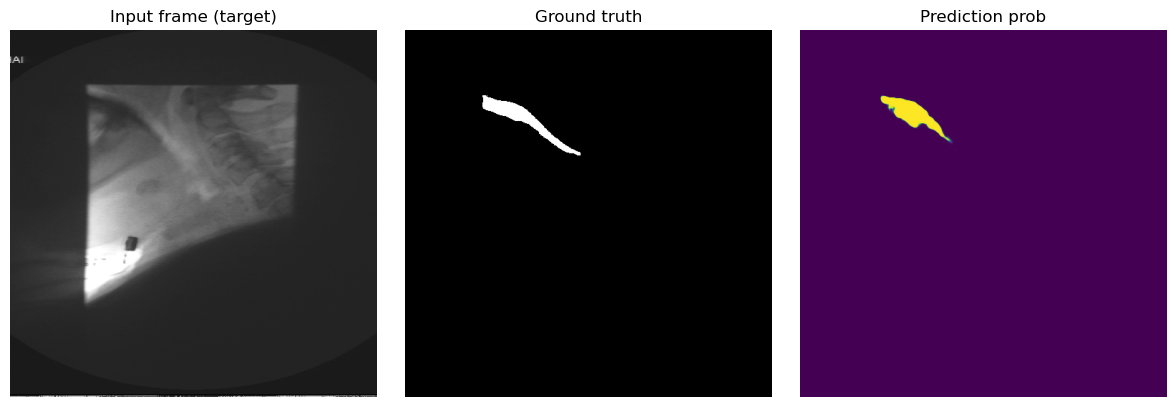

In [6]:

# Evaluation on test set + qualitative example (memory-friendly)
import matplotlib.pyplot as plt

# Free GPU cache before eval
if torch.cuda.is_available():
    torch.cuda.empty_cache()

if BEST_PATH.exists():
    model.load_state_dict(torch.load(BEST_PATH, map_location=device))
model.eval()

# To avoid huge memory use for AUC, subsample up to this many pixels
MAX_AUC_PIXELS = 2_000_000
auc_probs, auc_targs = [], []
pixels_accum = 0

all_counts = 0
metric_sums = {'dice': 0.0, 'iou': 0.0, 'sens': 0.0}
example = None

with torch.no_grad():
    for clips, masks in test_loader:
        clips = clips.to(device)
        masks = masks.to(device)
        preds = model(clips)

        # Move to CPU once per batch to save GPU memory
        preds_cpu = preds.detach().cpu()
        masks_cpu = masks.detach().cpu()

        # Metrics per-sample
        for b in range(preds_cpu.shape[0]):
            dice, iou, sens = batch_metrics(preds_cpu[b:b+1], masks_cpu[b:b+1])
            metric_sums['dice'] += dice
            metric_sums['iou'] += iou
            metric_sums['sens'] += sens
            all_counts += 1
        if example is None:
            example = (clips[0].cpu(), masks_cpu[0], preds_cpu[0])

        # Subsample pixels for AUC to keep memory small
        if pixels_accum < MAX_AUC_PIXELS:
            flat_p = preds_cpu.flatten()
            flat_t = masks_cpu.flatten()
            keep = min(MAX_AUC_PIXELS - pixels_accum, flat_p.numel())
            if keep < flat_p.numel():
                idx = torch.randperm(flat_p.numel())[:keep]
                flat_p = flat_p[idx]
                flat_t = flat_t[idx]
            auc_probs.append(flat_p)
            auc_targs.append(flat_t)
            pixels_accum += flat_p.numel()

mean_metrics = {k: (v / all_counts if all_counts > 0 else float('nan')) for k, v in metric_sums.items()}
auc = compute_auc(auc_probs, auc_targs) if auc_probs else float('nan')
print('Test metrics:')
print('  Dice:', mean_metrics['dice'])
print('  IoU:', mean_metrics['iou'])
print('  Sensitivity:', mean_metrics['sens'])
print('  AUC (subsampled):', auc)

# Show one qualitative example
if example is not None:
    clip, mask, pred = example
    target_img = clip[TARGET_INDEX, 0].numpy()
    mask_np = mask[0].numpy()
    pred_np = pred[0].numpy()

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(target_img, cmap='gray')
    plt.title('Input frame (target)')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(mask_np, cmap='gray')
    plt.title('Ground truth')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(pred_np, cmap='viridis')
    plt.title('Prediction prob')
    plt.axis('off')
    plt.tight_layout()
    plt.show()
